# Biology Assignment 3

In [28]:
"""
# install the openslide tools in the OS
!apt-get install openslide-tools

# install the lib for python
!pip install openslide-python

# install the spams rquired for stain separation
! pip install spams 
"""
import numpy as np
import random as random
import matplotlib.pyplot as plt

#import openslide as ops
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
import skimage
from skimage import morphology
from skimage import measure
from skimage import io


import cv2


!pip install mahotas
import mahotas




     |████████████████████████████████| 1.5MB 4.5MB/s 
  Created wheel for mahotas: filename=mahotas-1.4.9-cp36-cp36m-linux_x86_64.whl size=4263962 sha256=cdc282f753864e5bcdcda9c444d278043c2e53f84108b2500eb1aec3b3f3d5df
  Stored in directory: /root/.cache/pip/wheels/02/e7/50/b67eee3b19c479cc5b41f10230bf9c1556be6eaaf095c6e997
Successfully built mahotas


In [29]:
!wget https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip

!unzip -o -q Kather_texture_2016_image_tiles_5000.zip

--2020-03-18 21:08:33--  https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip
Resolving zenodo.org (zenodo.org)... 188.184.95.95
Connecting to zenodo.org (zenodo.org)|188.184.95.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258098431 (246M) [application/octet-stream]
Saving to: ‘Kather_texture_2016_image_tiles_5000.zip.1’

Kather_texture_2016 100%[===================>] 246.14M  17.2MB/s    in 16s     

2020-03-18 21:08:50 (15.0 MB/s) - ‘Kather_texture_2016_image_tiles_5000.zip.1’ saved [258098431/258098431]



## Part 1

In [0]:
#This code opens all the images as an array
import os
from PIL import Image

Path = 'Kather_texture_2016_image_tiles_5000/'
filelist = os.listdir(Path)

Images = []
y = []

for s in filelist:
  P = Path + s
  filelist2 = os.listdir(P)
  for x in filelist2:
    y.append(s)
    im = Image.open(P + '/' + x)
    Images.append(np.array(im))


07_ADIPOSE


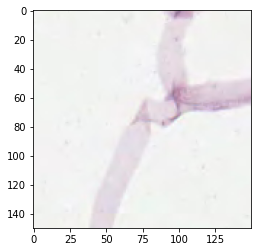

08_EMPTY


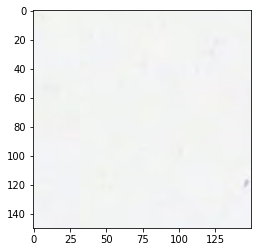

04_LYMPHO


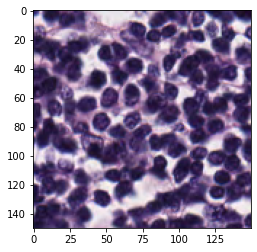

02_STROMA


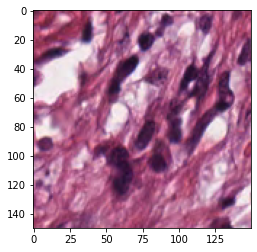

08_EMPTY


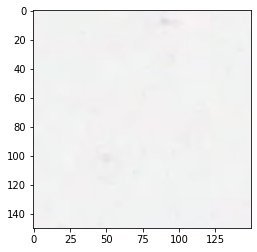

In [91]:
#A selection of images to see what they're like
import random
for i in range(5):
  ran = int(random.random()*5000)
  print(y[ran])
  plt.imshow(Images[ran])
  plt.show()



In [92]:
#This extracts the features 
from scipy.stats import entropy

print('mean')
#This calculates the mean of each of the channels
mean = []
for im in Images:
  m = []
  for i in range(3):
    line = im[:,:,i]
    m.append(np.mean(line))
  mean.append(m)

print('entropy')
#This calculates the entropy of each of the channels
entro = []
for im in Images:
  m = []
  for i in range(3):
    line = im[:,:,i]
    m.append(entropy(line.ravel()))
  entro.append(m)

print('variance')
#This calculates the variance of each of the channels
var = []
for im in Images:
  m = []
  for i in range(3):
    line = im[:,:,i]
    m.append(np.std(line)**2)
  var.append(m)

print('histogram')
#This calculates the histogram of each of the channels
his = []
for im in Images:
    h=[]
    color = ('b','g','r')
    for i,col in enumerate(color):
        hist = cv2.calcHist(im,[i],None,[20],[0,256])
        #plt.plot(hist,color = col)
        cv2.normalize(hist, hist)
        h.append(hist.ravel())
    his.append(h)
    #plt.show()

print('PCA')
#This calculates the singular values using the PCA of each of the channels

from sklearn.decomposition import PCA

pca = PCA(n_components=80,svd_solver='randomized')

Pca = []
for im in Images:
  m = []
  for i in range(3):
    pca.fit_transform(im[:,:,i])
    m.append(pca.singular_values_)
  Pca.append(m)

#These functions calculate the image momnets of a gray scale image
def fd_hu_moments(image):
    #Computes the Hu moments 
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature


def fd_haralick(image):
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(image).mean(axis=0)
    return haralick

print('Moments')

moments = []
for im in Images:
  m=[]
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  m.append(fd_hu_moments(im))
  m.append(fd_haralick(im))
  moments.append(m)


mean
entropy
variance
histogram
PCA
Moments


In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=80,svd_solver='randomized')

Pca = []
for im in Images:
  m = []
  for i in range(3):
    pca.fit_transform(im[:,:,i])
    m.append(pca.singular_values_)
  Pca.append(m)

In [0]:
from skimage.feature.texture import greycomatrix, local_binary_pattern
from scipy import stats

LBP=[]
for im in Images:
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
  #r = greycomatrix(gray, [1], [0, np.pi/2],normed=True)
  lbp = local_binary_pattern(gray, 10, 10, method='uniform')

  res = stats.cumfreq(lbp, numbins=12)

  frequency = []
  for i in range(len(res.cumcount)):
    if i == 0:
      frequency.append(res.cumcount[0]/22500)
    else:
      val = res.cumcount[i] - res.cumcount[i-1]
      frequency.append(val/22500)

  LBP.append(frequency)

In [0]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from skimage.util import img_as_float

def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

Gabor = []
for im in Images:
  Gabor.append(list(np.concatenate(compute_feats(cv2.cvtColor(im, cv2.COLOR_RGB2GRAY), kernels))))


In [0]:
#This code combines all the feature data for each image as a single array for each feature.
Xt = []
for i in range(len(his)):

  #m = mean[i] + var[i] + list(np.concatenate(Pca[i])) + list(entro[i]) + list(np.concatenate(his[i])) + list(np.concatenate(moments[i])) + LBP[i] + Gabor[i]
  #m = Gabor[i] + list(np.concatenate(Pca[i])) + list(entro[i]) + list(np.concatenate(moments[i])) + mean[i] + var[i]  
  m=  Gabor[i]+ list(np.concatenate(Pca[i])) + mean[i]
  Xt.append(np.array(m))

In [152]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.33, random_state=42)

clf = SVC(C=300.0, kernel='rbf', degree=5, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=100, 
          class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

clf.fit(np.array(X_train), y_train)

print(clf.score(X_test,y_test))
pred = clf.predict(X_test)

confusion_matrix(y_test, pred)


0.8715151515151515


array([[174,   3,   9,   3,   0,   7,   0,   0],
       [  1, 157,  19,   0,  26,   1,   0,   0],
       [  8,  12, 156,  12,   8,   8,   0,   0],
       [  2,   2,  14, 209,   0,   0,   0,   0],
       [  1,  11,   6,   0, 168,   5,   5,   0],
       [ 13,   1,   9,   4,   7, 176,   0,   0],
       [  0,   1,   0,   0,   4,   0, 196,   8],
       [  0,   1,   0,   0,   0,   0,   1, 202]])

## Part 2

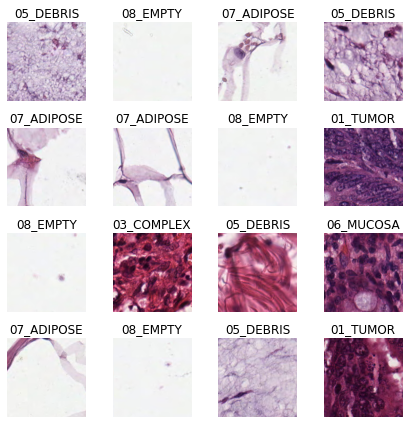

In [37]:
# Import The fast.ai Module & Load The Dataset
from fastai.vision import *
data = ImageDataBunch.from_folder('Kather_texture_2016_image_tiles_5000', valid_pct=0.2, seed=123)
data.show_batch(rows=4, figsize=(6,6))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


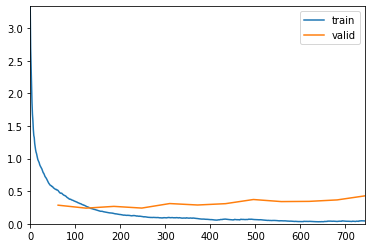

tensor(0.9180)


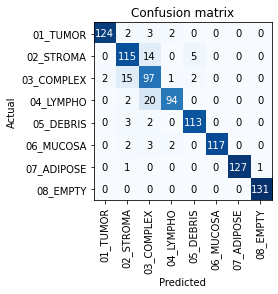

In [38]:
# Train The Model
learn = cnn_learner(data, models.resnet152, metrics=accuracy, callback_fns=ShowGraph)
learn.fit(12)
"""
resnet18, resnet34, resnet50, resnet101, resnet152
squeezenet1_0, squeezenet1_1
densenet121, densenet169, densenet201, densenet161
vgg16_bn, vgg19_bn
alexnet
"""

# Plot A Confusion Matrix
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
print(accuracy(preds, y)) # Same as accuracy in table from previous cell
interp.plot_confusion_matrix()

## Part 3

In [39]:
# install the openslide tools in the OS
!apt-get install openslide-tools

# install the lib for python
!pip install openslide-python

# install the spams rquired for stain separation
! pip install spams 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [40]:
import openslide as ops
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import tables
import os
import sys
import glob
import PIL
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import model_selection
import sklearn.feature_extraction.image
import random
!pip install unet
from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet
import scipy.ndimage 
import time
import math
import tables
import random
from sklearn.metrics import confusion_matrix
from skimage import io, morphology

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 2117091406706458258


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


aperio
<_PropertyMap {'aperio.AppMag': '40', 'aperio.DSR ID': 'ap1546-dsr', 'aperio.Date': '02/11/11', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': '23818', 'aperio.Focus Offset': '0.000000', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '23818', 'aperio.Left': '19.809914', 'aperio.LineAreaXOffset': '0.000000', 'aperio.LineAreaYOffset': '0.000000', 'aperio.LineCameraSkew': '-0.000389', 'aperio.MPP': '0.2520', 'aperio.OriginalHeight': '68904', 'aperio.OriginalWidth': '120000', 'aperio.ScanScope ID': 'SS1302', 'aperio.StripeWidth': '1000', 'aperio.Time': '14:13:57', 'aperio.Top': '20.922079', 'aperio.User': '72c4b55d-3d34-48d7-ba16-a1f39bc9cd0a', 'openslide.comment': 'Aperio Image Library v10.2.41\r\n120000x68904 [0,100 115109x68804] (256x256) J2K/YUV16 Q=70|AppMag = 40|StripeWidth = 1000|ScanScope ID = SS1302|Filename = 23818|Date = 02/11/11|Time = 14:13:57|User = 72c4b55d-3d34-48d7-ba16-a1f39bc9cd0a|MPP = 0

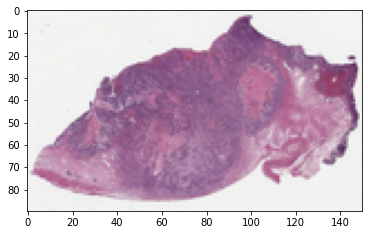

18
470368
((0, 0), 0, (151, 151))
(151, 151)


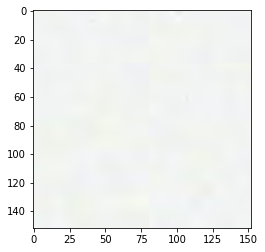

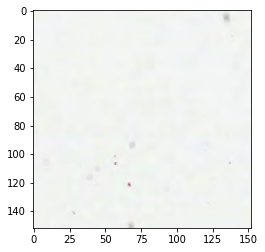

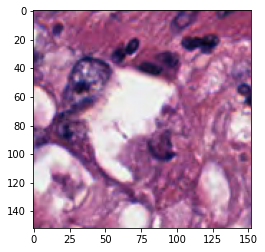

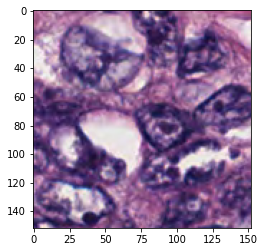

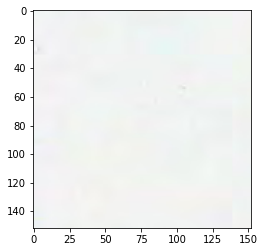

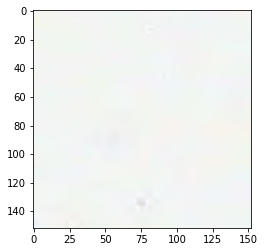

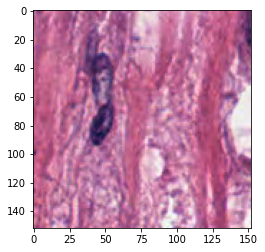

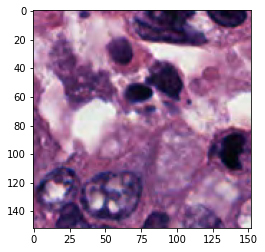

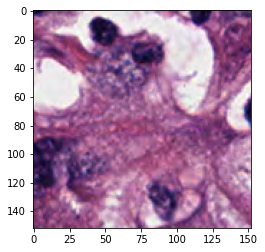

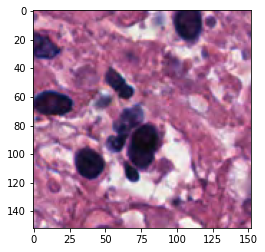

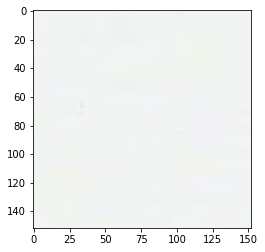

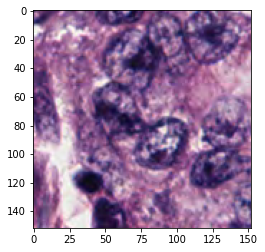

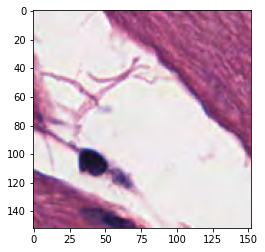

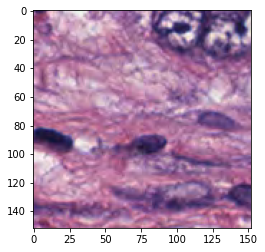

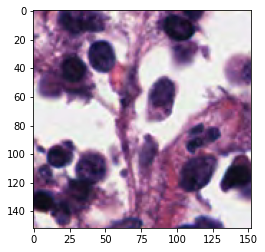

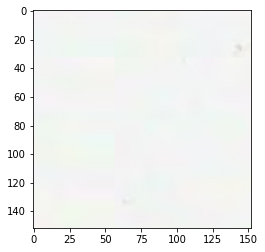

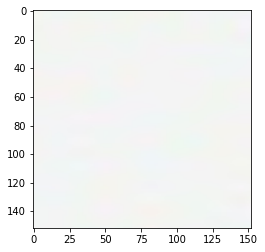

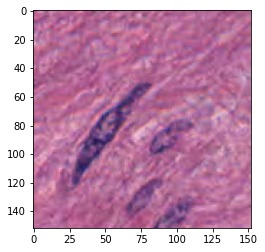

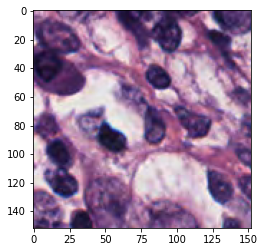

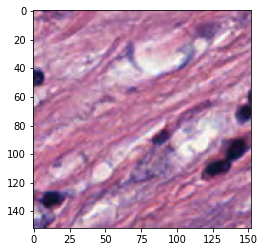

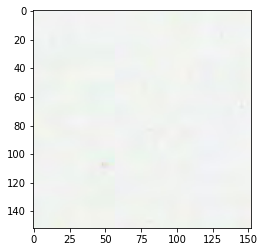

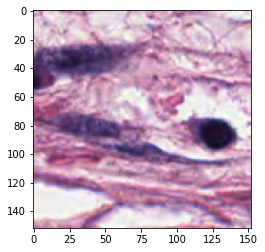

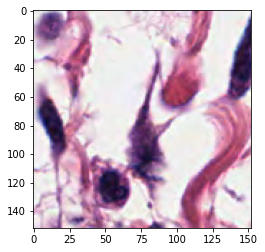

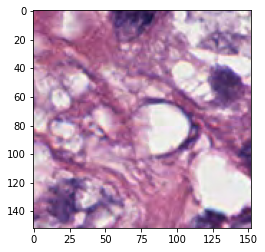

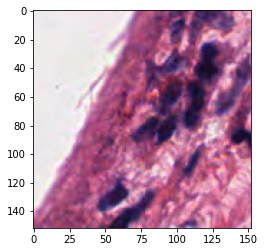

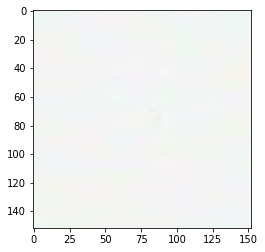

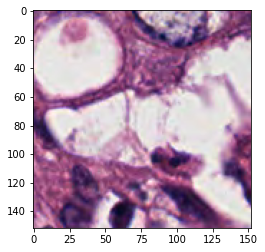

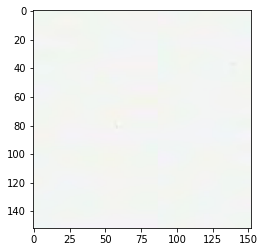

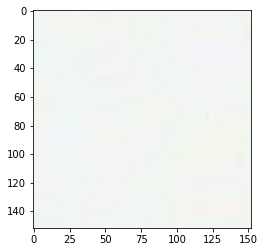

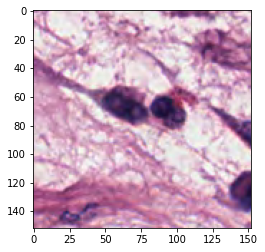

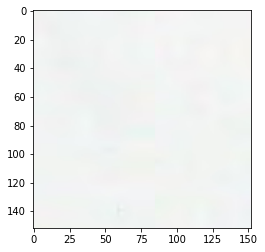

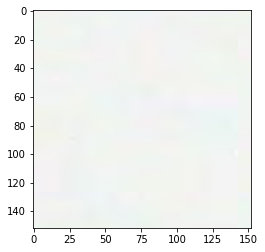

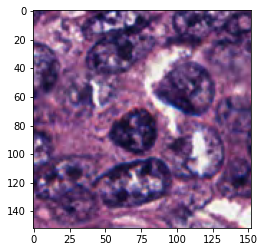

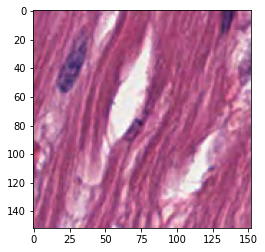

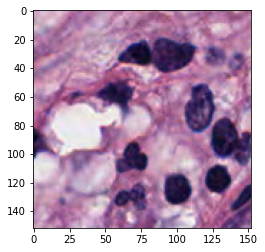

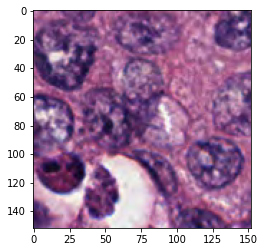

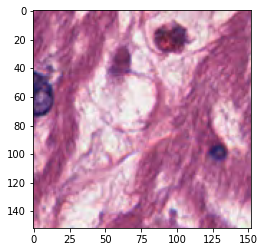

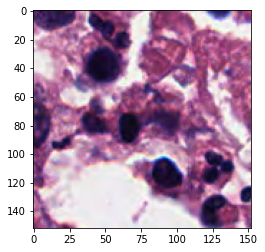

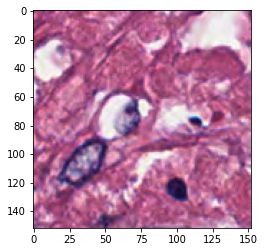

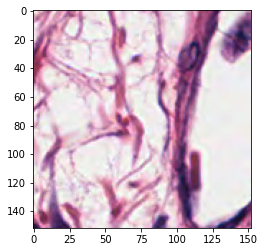

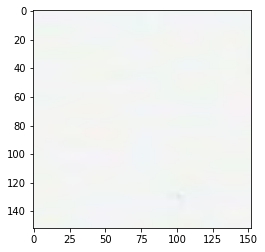

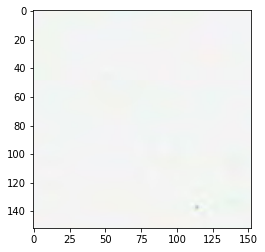

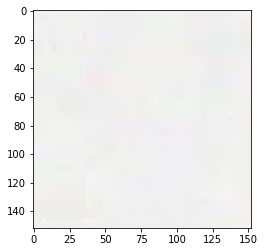

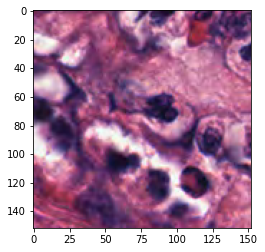

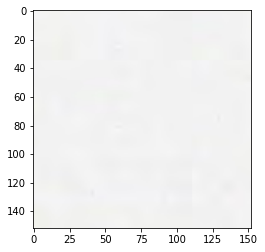

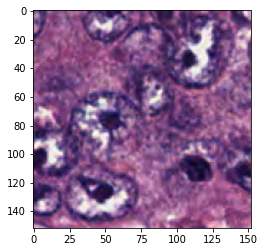

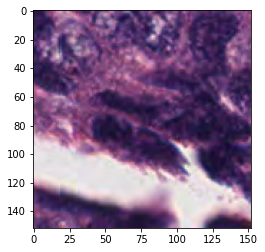

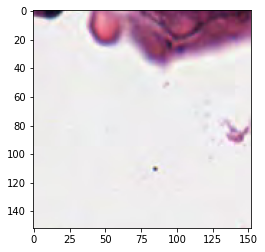

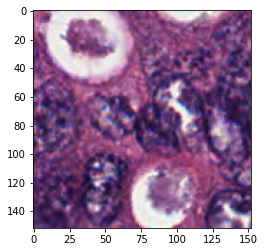

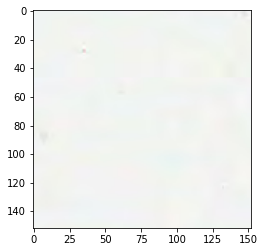

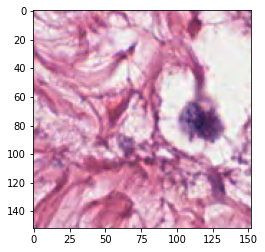

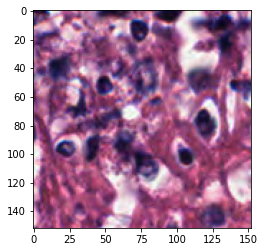

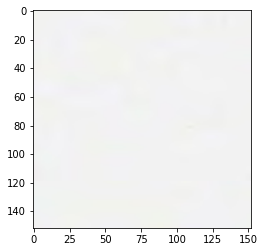

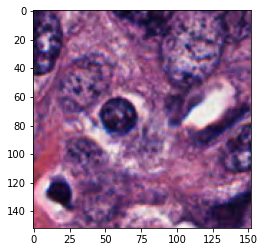

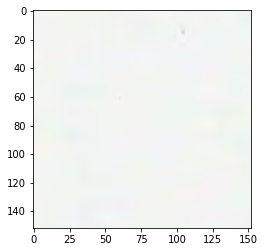

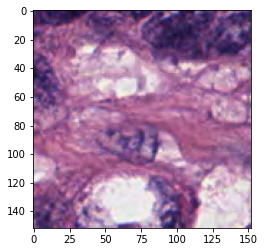

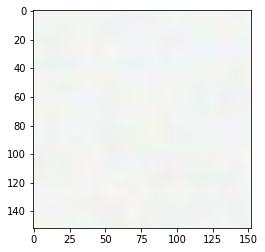

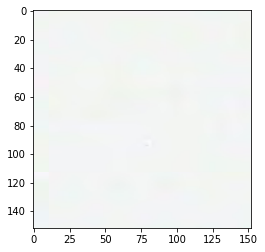

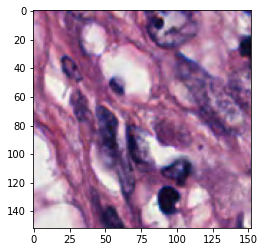

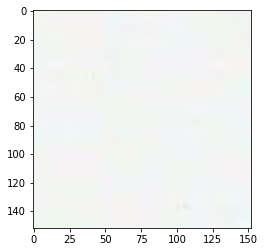

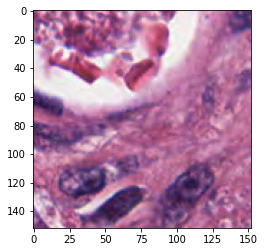

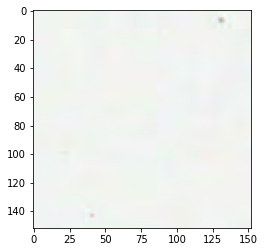

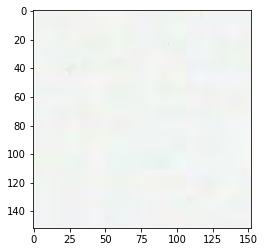

In [89]:
#This code produces patch images ready for classification

path = 'drive/My Drive/big.svs'
from openslide.deepzoom import DeepZoomGenerator

slide = ops.open_slide(path)
#ops.OpenSlide(path)
DeepZoomGenerator(slide)


print(slide.detect_format(path))

# slide of various attributes
print(slide.properties)

# 
downsamples = slide.level_downsamples

#Image size (width, height)
[w, h] = slide.level_dimensions[0]
print(w,h)

simg = slide.get_thumbnail((150,150))
#Show thumbnail
plt.imshow(simg)
plt.show()

#implement the function of DeepZoomGenerator
data_gen = DeepZoomGenerator(slide, tile_size=150, overlap=1, limit_bounds=False)

#The number of Deep Zoom levels in the image
print(data_gen.level_count)

#The total number of Deep Zoom tiles in the image
print(data_gen.tile_count)

#A list of (tiles_x, tiles_y) tuples for each Deep Zoom level. level_tiles[k] are the tile counts of level k
#print(data_gen.level_tiles)

#A list of (pixels_x, pixels_y) tuples for each Deep Zoom level. level_dimensions[k] are the dimensions of level k
#print(data_gen.level_dimensions)

read_region = data_gen.get_tile_coordinates(17, (0,0))
print(read_region)

#Return a (pixels_x, pixels_y) tuple for the specified tile.
print(data_gen.get_tile_dimensions(12, (0,0)))


tile_img1 = np.array(data_gen.get_tile(17,(8,10)))
tile_img2 = data_gen.get_tile(11,(2,1))
plt.imshow(tile_img1)
plt.show()
plt.imshow(tile_img2)
plt.show()

import random
NN = []
Classical = []
for ran in range(100):
  i = int(random.random()*115109/151)
  j = int(random.random()*115109/151)
  try:
    img = np.array(data_gen.get_tile(17,(i,j)))
    plt.imshow(img)
    plt.show()
  except:
    continue

In [43]:
print('Predicting ', len(NN), 'examples')
print(NN)
print(Classical)
a=0
for i in range(NN):
  if NN[i] == Clasical[i]:
    a+=1
print('The two predictions are ', a/len(NN), 'similar.')

[]
[]
